# **Machine Learning para Recomendação de Jogos**

Projeto feito para o Tech Challenge da fase 3 do curso de Machine Learning Engineering, da FIAP.

Integrantes:
- Bruno Pinheiro Mendes
- Matheus Fonseca Chaves
- Michelle Da Luz Rodrigues
---


## Sobre o modelo de ML

Pelas regras da FIAP, o modelo **deve** alimentar algo (aplicação, dashboard etc.), então decidimos criar um modelo capaz de, dado um jogo como entrada, recomendar jogos similares a ele.

O conjunto de dados utilizado foi o [Game Recommendations on Steam](https://www.kaggle.com/datasets/antonkozyriev/game-recommendations-on-steam), podendo ser acessado pela plataforma [Kaggle](https://kaggle.com).

## Configurações do projeto

Para o projeto proposto, decidimos utilizar a API do Kaggle para obter os dados.

Para utilizar a API é necessário:
1. Ter o Kaggle instalado no sistema
2. Criar uma pasta chamada *.kaggle*
3. Baixar o arquivo *kaggle.json* no site do Kaggle e colocá-lo dentro da pasta *.kaggle*

Após isso, utilizeremos a API para fazer o download e listagem do dataset alvo.

In [1]:
%pip install kaggle googletrans==4.0.0-rc1 scipy scikit-learn pandas seaborn matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## Sobre os dados - Análise exploratória

O repositório disponibiliza quatro conjuntos de dados:
- `games.csv`: informações sobre os jogos
- `games_metadata.json`: complementa os dados do arquivo acima, fornecendo mais dados sobre os jogos, como sua descrição e suas tags
- `recommendations.csv`: avaliações de usuários dadas aos jogos
- `users.csv`: contém a quantidade de jogos e reviews que o usuário fez

Abaixo, iremos entender melhor sobre cada um deles.

### Carregando os dados

In [2]:
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import hstack

/usr/lib/python3/dist-packages/pytz/__init__.py:31: SyntaxWarning: invalid escape sequence '\s'
  match = re.match("^#\s*version\s*([0-9a-z]*)\s*$", line)


In [4]:
df_games = pd.read_csv('../data/games.csv')
df_games_metadata = pd.read_json('../data/games_metadata.json', lines=True)
df_recommendations = pd.read_csv('../data/recommendations.csv')
df_users = pd.read_csv('../data/users.csv')

### Análise de `games.csv`

In [6]:
print(f'O dataset contém {df_games.shape[0]} linhas e {df_games.shape[1]} colunas')

O dataset contém 50872 linhas e 454 colunas


Significado de cada uma das colunas:

- app_id - ID do jogo na Steam
- title - Título do jogo
- date_release - Data de lançamento (yyyy-mm-dd)
- win - O jogo possui suporte para Windows?
- mac- O jogo possui suporte para MacOS?
- linux - O jogo possui suporte para Linux?
- steam_deck - O jogo possui suporte para Steam Deck?
- rating - Categoria de avaliação do jogo
- positive_ratio - Proporção de feedbacks positivos
- user_reviews - Quantidade de avaliações do jogo na página da Steam (ou seja, não necessariamente o valor irá bater com o que temos no dataset `recommendations.csv`)
- price_original - Preço em USD calculado antes do desconto
- discount - Percentual de desconto
- price_final - Preço em USD calculado após o desconto





In [7]:
df_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50872 entries, 0 to 50871
Columns: 454 entries, app_id to clean_description
dtypes: int64(449), object(5)
memory usage: 176.2+ MB


In [8]:
df_games.head(3)

,app_id,title,win,mac,linux,rating,positive_ratio,user_reviews,steam_deck,description,...,Western,Wholesome,Word Game,World War I,World War II,Wrestling,Zombies,eSports,clean_title,clean_description
0,13500,Prince of Persia: Warrior Within™,1,0,0,7,84,2199,1,Enter the dark underworld of Prince of Persia ...,...,0,0,0,0,0,0,0,0,prince of persia warrior within,enter the dark underworld of prince of persia ...
1,22364,BRINK: Agents of Change,1,0,0,6,85,21,1,NaN,...,0,0,0,0,0,0,0,0,brink agents of change,brink agents of change
2,113020,Monaco: What's Yours Is Mine,1,1,1,7,92,3722,1,Monaco: What's Yours Is Mine is a single playe...,...,0,0,0,0,0,0,0,0,monaco whats yours is mine,monaco whats yours is mine is a single player ...


In [9]:
print(f'''Há {df_games[df_games['app_id'] == 13500].user_reviews[0]} user_reviews na página do jogo na Steam,
mas apenas {df_recommendations[df_recommendations['app_id'] == 13500]['app_id'].count()} reviews deste mesmo jogo no dataset.''')

Há 2199 user_reviews na página do jogo na Steam,
mas apenas 1686 reviews deste mesmo jogo no dataset.


In [10]:
df_games['rating'].unique()

array([7, 6, 4, 5, 8, 2, 3, 0, 1])

### Análise de `games_metadata.json`

In [11]:
print(f'O dataset contém {df_games_metadata.shape[0]} linhas e {df_games_metadata.shape[1]} colunas')

O dataset contém 50872 linhas e 3 colunas


Sobre suas colunas:

- app_id - ID do jogo na Steam
- description - Descrição do jogo
- tags - Gêneros do jogo

In [12]:
df_games_metadata.sample(3)

,app_id,description,tags
30778,1815370,You need to build a team and get rewards throu...,"[Casual, Turn-Based Strategy, Idler, Relaxing,..."
42576,808220,Virtual Reality survival rogue-like game based...,"[Indie, Early Access, Simulation, Adventure, A..."
45447,1849710,,"[Action, Adventure, RPG, Massively Multiplayer..."


Na description podemos encontrar outros idiomas, caracteres especiais, textos mal escritos e/ou formatados e emojis. São coisas que precisam ser levadas em conta caso o projeto utilize esta coluna.

Suas tags seguem o padrão da Steam, sendo assim, elas estão em inglês e são valores categóricos.

In [13]:
df_games_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50872 entries, 0 to 50871
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   app_id       50872 non-null  int64 
 1   description  50872 non-null  object
 2   tags         50872 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [14]:
df_games_metadata[df_games_metadata['description'].str.strip() == '']

,app_id,description,tags
1,22364,,[Action]
7,271850,,"[Strategy, Simulation, Action, RTS, World War II]"
18,245950,,"[Action, RPG, FPS, Co-op, Shooter, Action RPG,..."
21,305181,,"[Adventure, Action]"
30,458790,,"[Adventure, Soundtrack, Visual Novel]"
...,...,...,...
50866,2362300,,[]
50867,2296380,,[]
50868,1272080,,[]
50869,1402110,,[]


In [15]:
df_games_metadata[df_games_metadata['tags'].apply(lambda x: x == [])]

,app_id,description,tags
33,371970,,[]
214,2277010,,[]
219,1600150,,[]
224,222573,,[]
287,919640,,[]
...,...,...,...
50866,2362300,,[]
50867,2296380,,[]
50868,1272080,,[]
50869,1402110,,[]


In [16]:
game_tags_count = df_games_metadata['tags'].explode().value_counts().reset_index(name='count')
game_tags_count

,tags,count
0,Indie,27957
1,Singleplayer,22566
2,Action,21897
3,Adventure,20183
4,Casual,17844
...,...,...
436,Volleyball,10
437,Hobby Sim,6
438,Tile-Matching,5
439,Fox,5


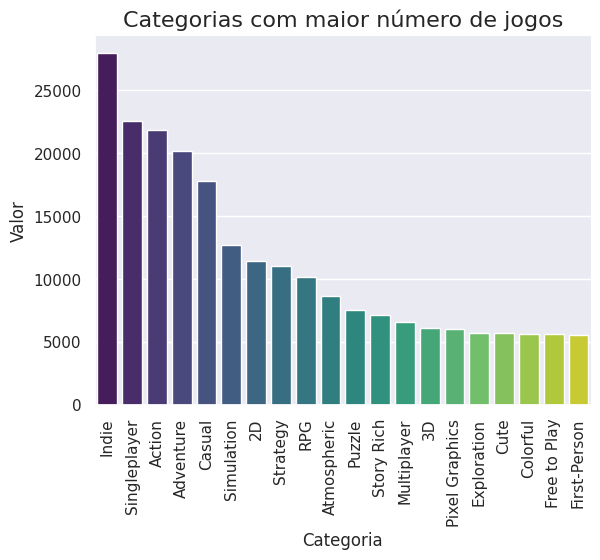

In [17]:
sns.set_theme()

# Criar o gráfico de barras
ax = sns.barplot(x='tags',
                 y='count',
                 hue='tags',
                 data=game_tags_count.nlargest(20, 'count'),
                 palette='viridis')

# Adicionar título e rótulos
ax.set_title('Categorias com maior número de jogos', fontsize=16)
ax.set_xlabel('Categoria', fontsize=12)
ax.set_ylabel('Valor', fontsize=12)

# Rotacionar os rótulos do eixo x para 90 graus
plt.xticks(rotation=90)

# Remover as bordas do gráfico
sns.despine()

# Exibir o gráfico
plt.show()

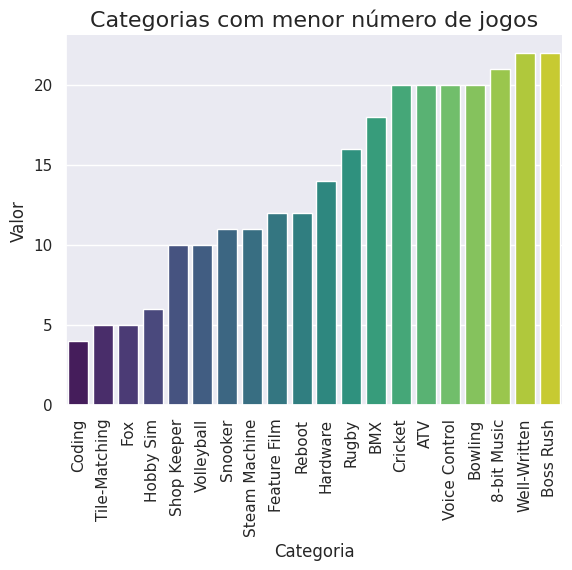

In [18]:
sns.set_theme()

# Criar o gráfico de barras
ax = sns.barplot(x='tags',
                 y='count',
                 hue='tags',
                 data=game_tags_count.nsmallest(20, 'count'),
                 palette='viridis')

# Adicionar título e rótulos
ax.set_title('Categorias com menor número de jogos', fontsize=16)
ax.set_xlabel('Categoria', fontsize=12)
ax.set_ylabel('Valor', fontsize=12)

# Rotacionar os rótulos do eixo x para 90 graus
plt.xticks(rotation=90)

# Remover as bordas do gráfico
sns.despine()

# Exibir o gráfico
plt.show()

Temos 411 categorias diferentes, futuramente, podemos tentar realizar um trabalho para tentar agrupá-las em categorias similares também, a fim de reduzir este número.

Além disso, ambas as colunas apresentam valores vazios - o texto vazio para 'description' e uma lista vazia para 'tags'. Ou seja, não podemos depender apenas destes valores para recomendar um jogo.

### Análise de `recommendations.csv`

Sobre suas colunas:

- app_id - ID do jogo na Steam
- helpful - Quantidade indicando se a avaliação foi marcada como útil
- funny - Quantidade indicando se a avaliação foi marcada como engraçada
- date - Data que a avaliação foi postada (yyyy-mm-dd)
- is_recommended - Indica se a avaliação está recomendando o jogo ou não
- hours - Quantidade de horas jogadas pelo usuário que postou a avaliação
- user_id - O id do usuário
- review_id - O id da avaliação

A tabela de recomendações é a maior dentre as que temos. Por mais que não tenah tantas colunas, apresenta um grande número de linhas.

In [19]:
print(f'O dataset contém {df_recommendations.shape[0]} linhas e {df_recommendations.shape[1]} colunas')

O dataset contém 41154794 linhas e 8 colunas


In [20]:
df_recommendations.sample(3)

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
30269366,130,0,0,2020-10-16,True,5.8,12193728,30269366
13689,1250410,0,0,2020-08-22,True,330.7,8073182,13689
15964849,2087030,2,0,2022-09-17,False,79.6,8715090,15964849


In [21]:
df_recommendations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41154794 entries, 0 to 41154793
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   app_id          int64  
 1   helpful         int64  
 2   funny           int64  
 3   date            object 
 4   is_recommended  bool   
 5   hours           float64
 6   user_id         int64  
 7   review_id       int64  
dtypes: bool(1), float64(1), int64(5), object(1)
memory usage: 2.2+ GB


Sendo uma tabela que indica as avaliações dos usuários, para o nosso caso (recomendação), precisamos ter um maior cuidado caso existam avaliações repetidas, pois isso pode influenciar no resultado final.

Já para o resto das colunas, elas irão representar valores auxiliares na recomendação, dando mais ou menos força para representar o quão bom o jogo é, principalmente a is_recommended e hours.

In [22]:
len(df_recommendations['review_id'].unique())

41154794

### Análise de `users.csv`

Sobre suas colunas:

- user_id - O id do usuário
- products - Quantidade de jogos que possui na conta
- reviews - Quantidade de reviews feitas

In [23]:
df_users.sample(10)

,user_id,products,reviews
8872325,429877,446,1
512629,13164767,151,1
6351230,13344885,2,1
8949247,11448854,113,3
5586061,6083584,151,1
551165,12692581,37,1
1691072,9965948,36,1
12784607,13401671,14,1
1788785,3716188,43,1
2618422,9463927,43,2


Os usuários daqui podem ser relacionados com a tabela de avaliações. As colunas `products` e `reviews` podem ajudar a criar uma métrica que consiga indicar uma maior relevância para suas avaliações.\
Ex.: um usuário que possui muitos produtos na conta e muitas reviews, provavelmente é uma pessoa com um perfil mais sério, portanto, sua avaliação poderia ser levada mais em conta do que outros usuários.

In [24]:
display(df_users.sort_values(by='products', ascending=False))
display(df_users.sort_values(by='reviews', ascending=False))

,user_id,products,reviews
9737072,11686938,32214,12
9447859,9970555,30124,10
13807061,6238999,30108,91
2261507,9617880,29752,107
4656255,9895433,29655,2
...,...,...,...
7356753,533746,0,1
7356750,533285,0,1
14305996,4939976,0,0
14305966,4899806,0,0


,user_id,products,reviews
4803549,11764552,7898,6045
9965497,5112758,1226,4152
13741354,11656130,1807,3840
12041089,5669734,4737,3479
8734053,11553593,1919,3392
...,...,...,...
14306039,4979144,24,0
14306038,4978747,3,0
14306037,4977291,12,0
14306036,4975288,18,0


# Como a recomendação será feita?

No final do projeto, queremos que o usuário escolha um jogo e receba recomendações de outros jogos similares.

Primeiramente, temos que definir o que fará um jogo ser recomendado.\
Temos alguns caminhos possíveis, mas imaginando como um produto real, o que os usuários mais querem é receber recomendações de jogos **no mínimo** com uma **jogabilidade** parecida.

Porém um jogo possui vários outros atributos, como:
- Estilo/jogabilidade;
- Nota - se o jogo é bem avaliado;
- Popularidade - se o jogo é conhecido;
- Preço

Com isso em mente, definimos um caminho para criar o modelo, sendo, inicialmente:
- O mínimo que queremos é que o algoritmo recomende jogos com um estilo/jogabilidade parecida
    - Ou seja, há bastante "peso" nas colunas de nome, descrição e gênero do jogo, pois elas serão, provavelmente, os maiores indicadores de jogos parecidos
- Não iremos utilizar o preço e data de lançamento no modelo
    - Não faz sentido que um jogo seja recomendado devido ao preço dele, portanto, na preparação dos dados, iremos removê-lo
    - Não queremos que um jogo tenha mais chances de ser similar a outro por seu preço ou data de lançamento
- Uma das formas de recomendação é encontrar usuários com os mesmos gostos, então também podemos tentar levar isso em conta
    - Esse tipo de recomendação é mais útil quando temos uma conta ativa sendo utilizada, que não é o caso do nosso projeto
    - Ainda assim, podemos tentar utilizar o perfil dos usuários como um tipo de indicador de confiança. Ex.: usuários com mais jogos e avaliações, provavelmente farão um julgamento melhor do jogo

No final, dado um jogo como input para o modelo, ele deve recomendar outros jogos que sejam similares em jogabilidade e, possivelmente, também populares.

> Exemplo: Caso o jogo de input seja "Doom (1993)", seria interessante que outros jogos da mesma franquia fossem recomendados (devido a similaridade no nome, descrição e jogabilidade), mas caso um destes não seja tão popular, um outro jogo parecido com Doom poderia entrar na lista de recomendados, como "Wolfenstein 3D" ou outros jogos do mesmo gênero.

# Preparação dos dados (pré-processamento)

Aqui o objetivo é tratar e modificar os dados, a fim de uma melhor utilização em nosso modelo de ML.

### Removendo colunas desnecessárias

Conforme já falado acima, não queremos a influência do preço e nem de datas no modelo, portanto podemos remover essas coluna para deixar a base menor

In [4]:
df_games.head(1)

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck
0,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.0,True


In [5]:
df_games.drop(columns=['date_release', 'price_final', 'price_original', 'discount'], inplace=True)
df_games.head(1)

,app_id,title,win,mac,linux,rating,positive_ratio,user_reviews,steam_deck
0,13500,Prince of Persia: Warrior Within™,True,False,False,Very Positive,84,2199,True


### Tratando valores categóricos

Queremos utilizar alguns campos de texto na análise, como o título, descrição e gêneros do jogo, porém o resto dos campos pode ser transformado diretamente em números

#### Coluna rating

Como as notas funcionam na Steam?

In [5]:
df_games.rating.unique()

array(['Very Positive', 'Positive', 'Mixed', 'Mostly Positive',
       'Overwhelmingly Positive', 'Negative', 'Mostly Negative',
       'Overwhelmingly Negative', 'Very Negative'], dtype=object)

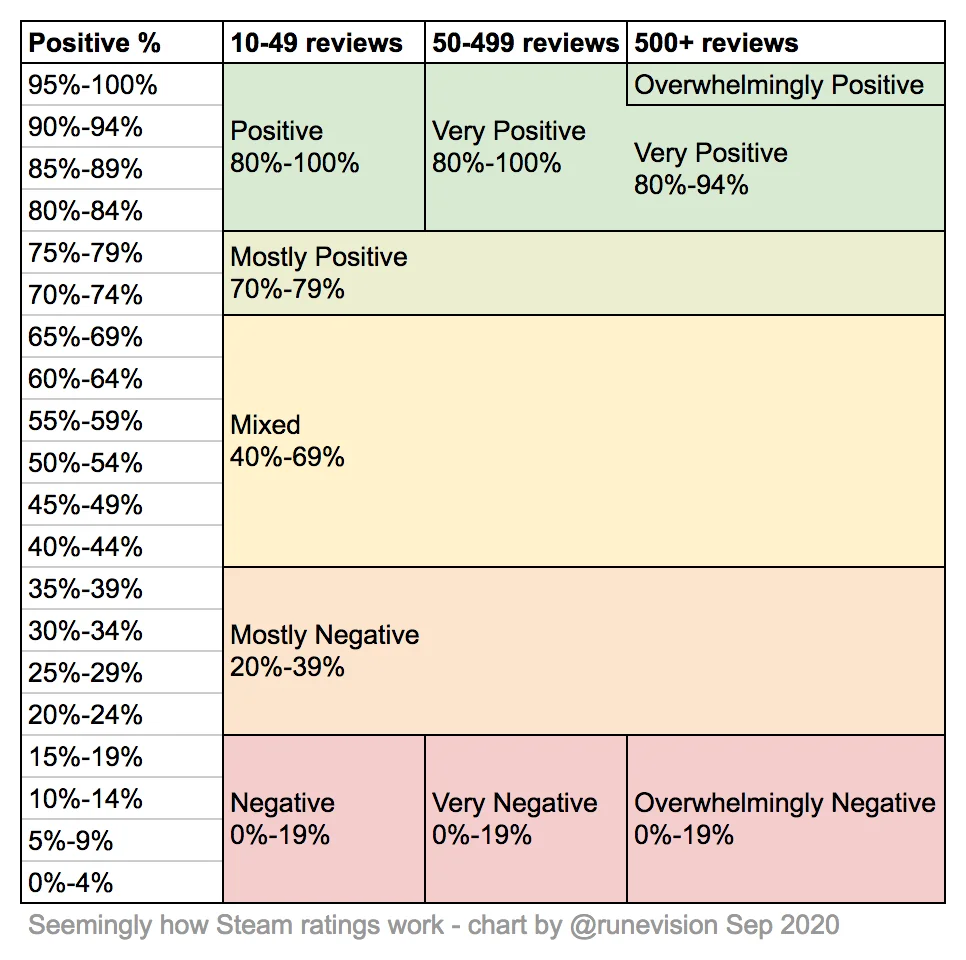

Por mais que o usuário apenas consiga recomendar ou não um jogo, pela imagem acima, percebe-se que temos 9 possíveis notas finais, que dependem tanto da avaliação do usuário quanto da quantidade total de avaliações que o jogo recebeu. Ou seja, além de ser um índice de qualidade, também indica popularidade.

Como as notas possuem uma ordem, decidimos transformar as categorias seguindo a ordem acima:

In [6]:
ratings_encoding = {
    'Overwhelmingly Negative': 0,
    'Very Negative': 1,
    'Negative': 2,
    'Mostly Negative': 3,
    'Mixed': 4,
    'Mostly Positive': 5,
    'Positive': 6,
    'Very Positive': 7,
    'Overwhelmingly Positive': 8
}

df_games['rating'] = df_games['rating'].map(ratings_encoding)
df_games.rating.unique()

array([7, 6, 4, 5, 8, 2, 3, 0, 1])

In [7]:
df_games[['rating', 'positive_ratio', 'user_reviews']]

,rating,positive_ratio,user_reviews
0,7,84,2199
1,6,85,21
2,7,92,3722
3,4,61,873
4,7,88,8784
...,...,...,...
50867,7,96,101
50868,3,38,29458
50869,7,89,1128
50870,7,95,82


Nos datasets temos colunas que indicam claramente a popularidade do jogo, mas podemos tentar analisá-las para criar novos indicadores.

#### Colunas sobre as plataformas que o jogo suporta

Todas elas possuem valores booleanos indicando se o jogo possui ou não suporte àquela plataforma. Sendo assim, apenas irei alterar para:
- 0: não possui suporte
- 1: possui suporte

In [8]:
# visualizando os valores nas colunas, para garantir que apenas possuem True e False
df_games[['win', 'mac', 'linux', 'steam_deck']].apply(lambda x: x.unique())

,win,mac,linux,steam_deck
0,True,False,False,True
1,False,True,True,False


In [9]:
df_games[['win', 'mac', 'linux', 'steam_deck']].head(1)

,win,mac,linux,steam_deck
0,True,False,False,True


In [10]:
df_games[['win', 'mac', 'linux', 'steam_deck']] = df_games[['win', 'mac', 'linux', 'steam_deck']].astype(int)
df_games[['win', 'mac', 'linux', 'steam_deck']].head(1)

,win,mac,linux,steam_deck
0,1,0,0,1


### Tratando valores numéricos abertos

O positive_ratio não parece precisar de tratamentos, pois vai de 0 até 100, representando uma porcentagem. Além disso, sua distribuição segue um padrão sólido:

Mínimo de ratio: 0
Máximo de ratio: 100
Distribuição de ratio: Axes(0.125,0.11;0.775x0.77)


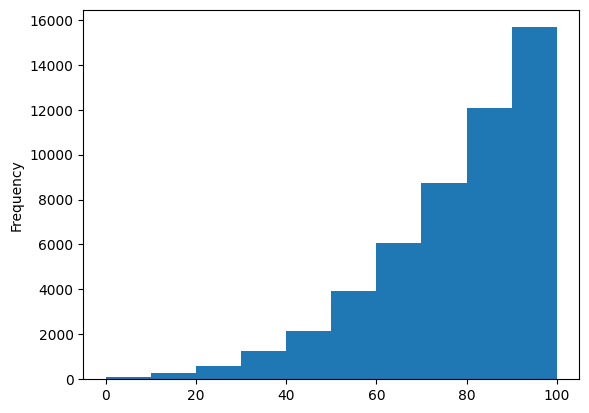

In [11]:
print(f'Mínimo de ratio: {df_games.positive_ratio.min()}')
print(f'Máximo de ratio: {df_games.positive_ratio.max()}')
print(f'Distribuição de ratio: {df_games.positive_ratio.plot(kind="hist")}')

Já as user_reviews servem como um índice de popularidade do jogo, mostrando o quanto o jogo é popular. Não precisamos tratar este campo também, já que a análise demonstrou que apenas há números e não temos nulos

In [12]:
df_games.user_reviews.describe()

count    5.087200e+04
mean     1.824425e+03
std      4.007352e+04
min      1.000000e+01
25%      1.900000e+01
50%      4.900000e+01
75%      2.060000e+02
max      7.494460e+06
Name: user_reviews, dtype: float64

A distribuição do número de reviews é "ruim", pois poucos jogos (comparados ao número do dataset) se destacam muito mais do que outros.

Ainda assim, provavelmente não será um problema, já que isso apenas pode ser utilizado, no nosso caso, para definir a popularidade do jogo e/ou qualidade das avaliações dadas.

In [13]:
df_games[['title', 'user_reviews']].sort_values(by='user_reviews', ascending=False).head(10)

,title,user_reviews
14398,Counter-Strike: Global Offensive,7494460
47770,PUBG: BATTLEGROUNDS,2217226
13176,Dota 2,2045628
12717,Grand Theft Auto V,1484122
14535,Tom Clancy's Rainbow Six® Siege,993312
47380,Team Fortress 2,985819
13035,Terraria,943413
15363,Garry's Mod,853733
13173,Rust,786668
14376,Apex Legends™,713182


<Axes: ylabel='Frequency'>

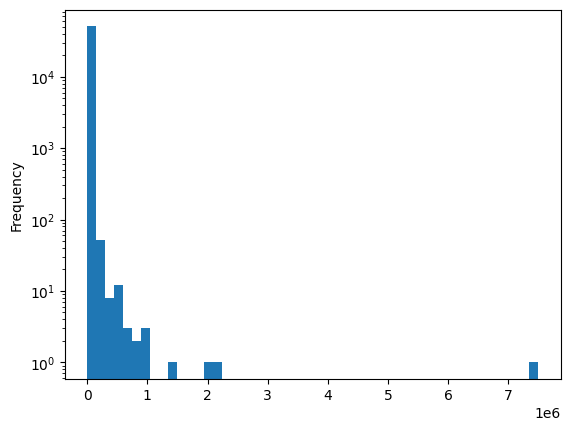

In [14]:
df_games.user_reviews.plot(kind='hist', bins=50, logy=True)

### Lidando com os textos

#### Inserindo description e tags na `df_games`

Conforme dito anteriormente, há três colunas de texto importantes quando o assunto é assimilar um jogo com outro:
- Título
- Descrição
- Gêneros

Então iremos incluir as colunas de gênero descrição em nossa tabela.

In [5]:
df_games[df_games['app_id'] == 13500]

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck
0,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.0,True


In [6]:
df_games_metadata[df_games_metadata['app_id'] == 13500]

,app_id,description,tags
0,13500,Enter the dark underworld of Prince of Persia ...,"[Action, Adventure, Parkour, Third Person, Gre..."


In [7]:
print(f'O tamanho das bases é igual? {len(df_games) == len(df_games_metadata)}')

O tamanho das bases é igual? True


In [8]:
df_games = pd.merge(df_games, df_games_metadata, on='app_id', how='inner')
df_games[df_games['app_id'] == 13500]

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck,description,tags
0,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.0,True,Enter the dark underworld of Prince of Persia ...,"[Action, Adventure, Parkour, Third Person, Gre..."


#### Tratando as tags (gêneros)

Por mais que as tags sejam valores categóricos, temos duas alternativas:
- Juntá-las as outras colunas de texto
- Realizar o one-hot encoding

Não sabemos qual irá resultar no melhor modelo, portanto, iremos tentar as duas alternativas

**One-hot encoding das categorias**

In [9]:
tags_dummies = pd.get_dummies(df_games['tags'].explode()).groupby(level=0).sum()
tags_dummies

,1980s,1990's,2.5D,2D,2D Fighter,2D Platformer,360 Video,3D,3D Fighter,3D Platformer,...,Well-Written,Werewolves,Western,Wholesome,Word Game,World War I,World War II,Wrestling,Zombies,eSports
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50867,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50868,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50869,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50870,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
df_games = pd.concat([df_games, tags_dummies], axis=1)
df_games.sample(5)

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,...,Well-Written,Werewolves,Western,Wholesome,Word Game,World War I,World War II,Wrestling,Zombies,eSports
38559,1047150,LAMUNATION! -international- Vocal Collection,2019-12-04,1,0,0,6,100,14,0.99,...,0,0,0,0,0,0,0,0,0,0
49670,1344120,Bistro Days,2022-02-25,1,1,0,6,100,10,7.79,...,0,0,0,0,0,0,0,0,0,0
14806,237800,Remember Me: Combo Lab Pack DLC,2013-08-23,1,0,0,5,72,58,3.99,...,0,0,0,0,0,0,0,0,0,0
46548,2295390,Mr. Mat Hematic,2023-02-26,1,0,0,5,79,53,0.00,...,0,0,0,0,0,0,0,0,0,0
46972,1942450,Gemlands,2022-04-09,1,0,0,6,80,10,0.99,...,0,0,0,0,0,0,0,0,0,0


Validando se o hot-encoding funcionou corretamente:

In [22]:
# Todas as colunas que aparecerem no array abaixo devem possuir o número 1 como valor
genres_2272250 = df_games[df_games['app_id'] == 2272250]['tags'].values[0]
print(genres_2272250)
df_games.loc[df_games['app_id'] == 2272250, genres_2272250]

['Early Access', 'FPS', 'Action', 'Retro', 'First-Person', 'Lovecraftian', 'Atmospheric', '3D', 'Shooter', 'Singleplayer', 'Old School', 'Horror', 'Violent', 'Combat', 'Cartoony', 'Stylized', 'Psychedelic', 'Gore', 'Adventure', 'Character Customization']


,Early Access,FPS,Action,Retro,First-Person,Lovecraftian,Atmospheric,3D,Shooter,Singleplayer,Old School,Horror,Violent,Combat,Cartoony,Stylized,Psychedelic,Gore,Adventure,Character Customization
50870,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [23]:
(df_games.loc[df_games['app_id'] == 2272250, genres_2272250].values == 1).all()

np.True_

#### Tratando `title` e `description`

Estas colunas possuem caracteres diferentes dos latinos, sendo necessário ter certeza que os tratamentos de encoding irão funcionar nelas de forma adequada.

Uma boa abordagem pode ser identificar algumas linhas assim e depois checar se estes índices foram transformados corretamente

In [25]:
non_ascii_regex = r'[^\x00-\x7F]+'

# with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):
#     display(df_games[df_games['title'].str.contains(non_ascii_regex, regex=True) |
#                      df_games['description'].str.contains(non_ascii_regex, regex=True)][['title', 'description']])

df_games[df_games['title'].str.contains(non_ascii_regex, regex=True) |
         df_games['description'].str.contains(non_ascii_regex, regex=True)][['title', 'description']].sample(10)

,title,description
16417,Riders Republic™ Year 1 Pass,
29743,Ookibloks,Ookibloks combines the spirit of classic actio...
35526,ACE COMBAT™ 7: SKIES UNKNOWN - ADF-01 FALKEN Set,
47090,ACE COMBAT™ 7: SKIES UNKNOWN 25th Anniversary ...,
13843,PBA Pro Bowling 2023,The ultimate bowling game is back with PBA Pro...
40357,Dog Duty,As some evil bigwig Octopus Commander and his ...
38749,Drawn™: Dark Flight,A kingdom’s future rests in the light of three...
2813,Night Call,Friend. Confidant. Therapist. Voyeur. As a cab...
15556,EverQuest II,EverQuest® II is the epitome of massively mult...
18116,[Chilla's Art] Hanako | 花子さん,Hanako | 花子さん is a Japanese survival horror ad...


Analisando os títulos e descrições acima, percebemos algumas coisas:
- Há descrições vazias
- Temos idiomas diferentes do inglês, como no jogo "風色幻想5:赤月戰爭", onde seu título e descrição estão em chinês. Logo, precisamos ter cuidado ao tratar estes caracteres para não apagar totalmente o jogo.
- Nos títulos temos muitos caracteres especiais, que muitas vezes não aparecem na descrição do jogo.
    - Ex.: "Prince of Persia: Warrior Within™" há o caractere "™" no título, mas ele não aparece na descrição
    - Nesses casos, seria interessante remover o caractere especial, a fim de criar um título mais próximo da descrição
- Nas descrições, muitas vezes temos emojis, algumas vezes entre os textos, como no jogo "Dinky Guardians". Talvez isso atrapalhe na relação dos textos, então seria interessante remover todos os emojis.
    - Ex.: As descrições "Build a 🚀Rocket" e "Build a Rocket" são iguais, porém o emoji no meio pode distanciar seu significado no algoritmo, prejudicando o modelo de encontrar a similaridade entre as descrições

##### Tratamento geral dos textos

Remover emojis, deixar tudo minúsculo, remoção de caracteres especiais, etc.

In [26]:
def contains_chinese(text):
    chinese_char_pattern = re.compile(r'[\u4e00-\u9fff]+')
    return bool(chinese_char_pattern.search(text))


def remove_emojis(text):
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # Emoticons
        "\U0001F300-\U0001F5FF"  # Símbolos e pictogramas
        "\U0001F680-\U0001F6FF"  # Símbolos de transporte e mapas
        "\U0001F1E0-\U0001F1FF"  # Bandeiras (alfabeto regional)
        "\U00002500-\U00002BEF"  # Setas e símbolos variados
        "\U00002702-\U000027B0"  # Outros tipos de símbolos e pictogramas
        "\U000024C2-\U0001F251"  # Diversos símbolos extras
        "\U0001F900-\U0001F9FF"  # Símbolos e pictogramas de extensão
        "\U0001FA70-\U0001FAFF"  # Novos pictogramas e símbolos adicionais
        "\U00002600-\U000026FF"  # Diversos símbolos como ☀️, ⛅, ☁️
        "\U0001F7E0-\U0001F7FF"  # Quadrados coloridos, etc.
        "\U0001F780-\U0001F7D8"  # Círculos e quadrados coloridos
        "]+", flags=re.UNICODE)

    if (contains_chinese(text)):
        emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # Emoticons
        "\U0001F300-\U0001F5FF"  # Símbolos e pictogramas
        "\U0001F680-\U0001F6FF"  # Símbolos de transporte e mapas
        "\U0001F1E0-\U0001F1FF"  # Bandeiras (alfabeto regional)
        "\U0001F900-\U0001F9FF"  # Símbolos e pictogramas de extensão
        "\U0001FA70-\U0001FAFF"  # Novos pictogramas e símbolos adicionais
        "\U0001F7E0-\U0001F7FF"  # Quadrados coloridos, etc.
        "\U0001F780-\U0001F7D8"  # Círculos e quadrados coloridos
        "]+", flags=re.UNICODE)

    return emoji_pattern.sub(r'', text).strip().lower()


def remove_special_chars(text):
    special_char_pattern = re.compile(r'[™©®…<>#$%^&*+=\[\]{}|\\/~`.,;:!?\'\"()/]')
    return special_char_pattern.sub(r'', text)

df_games['clean_title'] = df_games['title'].apply(lambda x: remove_emojis(remove_special_chars(x)))
df_games['clean_description'] = df_games['description'].apply(lambda x: remove_emojis(remove_special_chars(x)))

In [27]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):
    display(df_games[df_games['title'].str.contains(non_ascii_regex, regex=True) |
                     df_games['description'].str.contains(non_ascii_regex, regex=True)][['title', 'clean_title', 'description', 'clean_description']].sample(10))

,title,clean_title,description,clean_description
7639,Gunvolt Chronicles: Luminous Avenger iX - Extra Song: 'Raison d'être',gunvolt chronicles luminous avenger ix - extra song raison dêtre,,
1975,Nancy Drew®: The Phantom of Venice,nancy drew the phantom of venice,Infiltrate a Carnevale of Criminals in Italy!,infiltrate a carnevale of criminals in italy
5259,Koloro,koloro,"Between dreams and nightmares, “Koloro” tells the tale of a young pink hair girl named Kora who embarks on a quest to find her missing sister through a stunning Puzzle-Platformer crafted by Sköll Studio.",between dreams and nightmares “koloro” tells the tale of a young pink hair girl named kora who embarks on a quest to find her missing sister through a stunning puzzle-platformer crafted by sköll studio
25471,HORGIHUGH (ホーギーヒュー),horgihugh,"HORGIHUGH is a horizontal side-scrolling shoot 'em up from Japanese developer PiXEL featuring vibrant retro graphics, intense boss battles, a unique power-up system, and an adorable roster of anthropomorphic characters.",horgihugh is a horizontal side-scrolling shoot em up from japanese developer pixel featuring vibrant retro graphics intense boss battles a unique power-up system and an adorable roster of anthropomorphic characters
36034,Map Of Materials,map of materials,"In ""Map Of Materials"", Vincent’s exciting adventure awaits you. You find him stranded on a mysterious island where he uses all his skills and knowledge to escape and return to his old life.",in map of materials vincent’s exciting adventure awaits you you find him stranded on a mysterious island where he uses all his skills and knowledge to escape and return to his old life
2798,Tabletopia,tabletopia,"Tabletopia is a sandbox virtual table with high-quality board games and ready setups. Already 2000+ games and counting! Play how you want with whom you want: guests don’t need accounts to play. Or make your own games, no programming skills required.",tabletopia is a sandbox virtual table with high-quality board games and ready setups already 2000 games and counting play how you want with whom you want guests don’t need accounts to play or make your own games no programming skills required
19059,AKIBA'S TRIP: Undead ＆ Undressed,akibas trip undead undressed,"In Tokyo’s popular ”Electric Town” district, Akihabara, vampires called “Synthisters” walk among us. You must identify and dispose of them the only way you know how – by engaging them in hand-to-hand combat in order to strip them of their clothes so their bodies melt away in the sunlight.",in tokyo’s popular ”electric town” district akihabara vampires called “synthisters” walk among us you must identify and dispose of them the only way you know how – by engaging them in hand-to-hand combat in order to strip them of their clothes so their bodies melt away in the sunlight
37218,Let Hawaii Happen VR,let hawaii happen vr,"Visiting Hawaii as a tourist is amazing. But when you get to “Let Hawaii Happen” with a local as your guide, it’s a totally different experience. Start by paragliding into an island of your choice. Then, upon landing, a local will give you the most personal tour of their island — virtually-speaking.",visiting hawaii as a tourist is amazing but when you get to “let hawaii happen” with a local as your guide it’s a totally different experience start by paragliding into an island of your choice then upon landing a local will give you the most personal tour of their island — virtually-speaking
10048,In the Raven Shadow – Ve stínu havrana,in the raven shadow – ve stínu havrana,In the Raven Shadow is in the best sense an old-fashioned adventure game for all sense-seeking people.,in the raven shadow is in the best sense an old-fashioned adventure game for all sense-seeking people
6093,ILLUMINATI,illuminati,"Join the conspiracy of global domination and dark satire in this classic from Steve Jackson Games. As one of the Illuminati, you are driven by power, money, mayhem—and more. Grow stronger as you p

##### Traduzindo os textos

Em alguns casos, o título e/ou descrição do jogo é composto pelo nome em inglês e outro idioma, nesses casos, não há problema, pois o algoritmo irá conseguir associar a similaridade dos textos.

Exemplo: o título "*ШХД: ЗИМА / IT'S WINTER*" contém texto em inglês, sendo identificável em outros textos em inglês, facilitando a busca pelo algoritmo. Já o título "廃病院探索" é totalmente em outro idioma, não sendo identificado com o inglês.

Por conta disso, decidimos traduzir os títulos e descrições que são totalmente compostos por caracteres não-latinos.

In [28]:
# regex que inclui caracteres não-latinos com exceção de pontuações e números
non_ascii_full_regex = r'^[^\x00-\x7F\d.,:;!?\'"()\-–…\s]+[\d.,:;!?\'"()\-–…\s]*$'

df_games[df_games['clean_title'].str.match(non_ascii_full_regex, na=False) |
         df_games['clean_description'].str.match(non_ascii_full_regex, na=False)][['clean_title', 'clean_description']]

,clean_title,clean_description
355,bishojo mangekyo kotowari to meikyu no shojo,玩家将和故事中性格各异的角色一起，解开神秘超自然事件的真相。并逐步了解贯穿整部游戏的核心——...
401,猎魔者战纪,这是一款轻松休闲的角色扮演游戏，和米娅一起冒险，发现深藏在王国深处的秘密。
408,风信楼,昏君误国，怨声载道，无数野心家暗起反心。在京城一家青楼的掩饰下，你培养手下、积攒钱财、收集情...
424,花落冬陽 snowdreams -lost in winter-,《花落冬陽》是一款以「夢想」與「思念」為主題的文字冒險遊戲。故事講述主角謝子臣在追尋作家之夢...
553,天师,《天师》是一款以中国修真文化和鬼怪传说为题材的独立游戏，也是我们团队的第二款游戏。玩家将扮演...
...,...,...
50601,廃病院探索,this is a horror game that asks a friend to fi...
50602,神曲,十年经典rpg大作
50660,龙傲天的多元宇宙,this is a role-playing game in which players p...
50704,午前五時にピアノを弾く,piano at 5 am is a short text adventure game a...


In [29]:
from googletrans import Translator
import time

translator = Translator()

def translate_text(text, retries=5):
    attempt = 0
    while attempt < retries:
        try:
            translator.raise_Exception = True
            translated_text = translator.translate(text, dest='en').text
            time.sleep(1)
            return remove_special_chars(f'{translated_text} ({text})').strip().lower()
        except BaseException as error:
            if '429' in str(error):
                print(f'Erro 429 detectado. Tentando novamente após espera...\nTentativa {attempt+1}/{retries}')
                time.sleep(5 + attempt * 5)
                attempt += 1
            else:
                print(f'Erro ao traduzir: {text}\n{error}\n')
                return text
    print(f'Falha ao traduzir após {retries} tentativas: {text}')
    return text

In [30]:
translated_indexes = df_games[df_games['clean_title'].str.match(non_ascii_full_regex, na=False) |
                              df_games['clean_description'].str.match(non_ascii_full_regex, na=False)].index

print(f"Qtd títulos 100% em outro idioma: {len(df_games[df_games['clean_title'].str.match(non_ascii_full_regex, na=False)]['clean_title'])}")
print(f"Qtd descrições 100% em outro idioma: {len(df_games[df_games['clean_description'].str.match(non_ascii_full_regex, na=False)]['clean_description'])}")
print(f"Índices: {translated_indexes}")

Qtd títulos 100% em outro idioma: 492
Qtd descrições 100% em outro idioma: 239
Índices: Index([  355,   401,   408,   424,   553,   679,   686,   762,  1283,  1359,
       ...
       50531, 50545, 50558, 50568, 50576, 50601, 50602, 50660, 50704, 50754],
      dtype='int64', length=615)


In [31]:
df_games.loc[df_games['clean_title'].str.match(non_ascii_full_regex, na=False), 'clean_title'] = df_games[df_games['clean_title'].str.match(non_ascii_full_regex, na=False)]['clean_title'].apply(translate_text)

In [32]:
df_games.loc[df_games['clean_description'].str.match(non_ascii_full_regex, na=False), 'clean_description'] = df_games[df_games['clean_description'].str.match(non_ascii_full_regex, na=False)]['clean_description'].apply(translate_text)

In [33]:
df_games.to_csv('df_games_traduzido.csv', index=False)

In [35]:
print(f"Qtd títulos 100% em outro idioma: {len(df_games[df_games['clean_title'].str.match(non_ascii_full_regex, na=False)]['clean_title'])}")
print(f"Qtd descrições 100% em outro idioma: {len(df_games[df_games['clean_description'].str.match(non_ascii_full_regex, na=False)]['clean_description'])}")

with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):
    display(df_games.iloc[translated_indexes][['clean_title', 'clean_description']].sample(10))

Qtd títulos 100% em outro idioma: 0
Qtd descrições 100% em outro idioma: 0


,clean_title,clean_description
30262,unlimited dimension 无限次元,a japanese strategy adventure game operate a protagonist match lineup equipment skills etc to form a combat team instant combat system rougelike plot role development sword and magic
5399,who said that the nanny cannot save the world 谁说奶妈不能拯救世界！,一款以探索为核心的rpg游戏！ 什么？你居然是一位被人们看不起的弱小牧师？ 通过你的智慧，收集情报，提升自我，然后去击败魔王来证明自己吧！
29835,魔卡幻想（heroines fantasy inherit）,classic strategy card battle game experience the fun of risk -through -level risk 经典策略卡牌对战游戏，体验集卡对战闯关冒险的乐趣！
18826,孤岛海妖 the sea-demon,a group of detective teams were invited by octopus island owners to challenge the sea demon suspension six years agothey need to complete the investigation within 24 hours and submit a answerfinally there were seven kinds of unique answers appeared 一组侦探小队受章鱼岛主人之邀，对六年前的海妖悬案发起挑战。她们需要在二十四小时内完成调查，并各自提交一份答案。最后，出现了七种截然不同的解答
23921,skating pig less 溜冰的猪少,icetime is a leisure action level game you need to complete the level through superb operation on the extremely slippery ice
31138,ergouzhi adventure 二狗子历险记,一款休闲娱乐的r p g游戏，游戏时间在30-50小时，没有无脑的boss战斗，都要稍微动点脑才能过关。 合理搭配队伍技能和词缀是你通关的关键所在。
50018,,i am thinking of suicidewelcome to club suicidea strange week to snuggle up to the boys thinking about suicidea novel adventure thinking about life 私は、自殺を考えている。クラブ・スーサイドへようこそ。自殺を考える少年達に寄り添う、奇妙な一週間。命を思考するノベルアドベンチャー。
43333,hyakume kaiyo goldfish 百詰怪軼與金魚,唯美奇幻的多結局視覺小說。 ──現實與非現實的交界處，被遺忘的人們交織而成的物語。
44254,the monster,qing is a pixel -style character -playing game with thrilling and depressed elementslate at night strange changes occurred in the home and the bizarre death and looming ghosts of the family seemed to be related to the clear twins who had been missing for a long timein order to investigate the truth of the matter the protagonist was trapped in fear and memories 《清》是一款具有惊悚和压抑元素的像素画风角色扮演类游戏。某天深夜，家中突然发生了奇怪的异变，家人的离奇惨死、若隐若现的鬼影这些仿佛都和失踪已久的双胞胎中的清有关。主角为了调查事情的真相，陷入了恐惧和回忆之中。
44130,linlin 琳琳,one night i noticed that the neighbor was making some noise as usual just at this moment i heard the cry of a girl from room f i used my superpowers to see what was going on next door what awaits the me will be a heinous and heartbreaking scene


In [4]:
df_games = pd.read_csv('df_games_traduzido.csv')

In [5]:
df_games.fillna('', inplace=True)

##### Tratando a descrição vazia

In [6]:
print(f'Temos {len(df_games[df_games["clean_description"] == ""])} linhas com a descrição vazia.')

Temos 10383 linhas com a descrição vazia.


In [13]:
df_games[['clean_title', 'clean_description']]

,clean_title,clean_description
0,prince of persia warrior within,enter the dark underworld of prince of persia ...
1,brink agents of change,
2,monaco whats yours is mine,monaco whats yours is mine is a single player ...
3,escape dead island,escape dead island is a survival-mystery adven...
4,dungeon of the endless,dungeon of the endless is a rogue-like dungeon...
...,...,...
50867,i expect you to die 3 cog in the machine,
50868,payday 3,
50869,eternights,
50870,forgive me father 2,embark on a journey into the darkest nightmare...


In [7]:
df_games.loc[df_games["clean_description"] == "", 'clean_description'] = df_games.loc[df_games["clean_description"] == "", 'clean_title']
df_games[['clean_title', 'clean_description']]

,clean_title,clean_description
0,prince of persia warrior within,enter the dark underworld of prince of persia ...
1,brink agents of change,brink agents of change
2,monaco whats yours is mine,monaco whats yours is mine is a single player ...
3,escape dead island,escape dead island is a survival-mystery adven...
4,dungeon of the endless,dungeon of the endless is a rogue-like dungeon...
...,...,...
50867,i expect you to die 3 cog in the machine,i expect you to die 3 cog in the machine
50868,payday 3,payday 3
50869,eternights,eternights
50870,forgive me father 2,embark on a journey into the darkest nightmare...


##### Aplicando TF-IDF

Uma maneira eficaz de extrair informações relevantes das colunas title e description é convertê-las em representações numéricas utilizando a técnica TF-IDF (Term Frequency-Inverse Document Frequency). Isso permite quantificar a importância de cada termo em relação ao conjunto de dados, facilitando a análise e a comparação entre os jogos com base em seus títulos e descrições.





In [15]:
# Deixar com stop_words em inglês
# tfidf = TfidfVectorizer(stop_words='english')
tfidf = TfidfVectorizer(stop_words=None)
title_tfidf = tfidf.fit_transform(df_games['clean_title'])
description_tfidf = tfidf.fit_transform(df_games['clean_description'])

#### Teste de modelo com title + description + tags

In [39]:
title_weight = 2.5
description_weight = 1.0
genres_weight = 3.0

X_text_genres = hstack([
    tags_dummies * genres_weight,
    title_tfidf * title_weight,
    description_tfidf * description_weight
])
X_text_genres

<COOrdinate sparse matrix of dtype 'float64'
	with 1959530 stored elements and shape (50872, 87820)>

In [40]:
model = NearestNeighbors(n_neighbors=5, metric='cosine')
model.fit(X_text_genres)

NearestNeighbors(metric='cosine')

In [23]:
def recommend_games(game_index, n_recommendations=5):
    distances, indices = model.kneighbors(X_text_genres.tocsr()[game_index:game_index+1], n_neighbors=n_recommendations+1)
    similar_games = df_games.iloc[indices[0]]
    return similar_games

In [41]:
recommend_games(0)

,app_id,title,win,mac,linux,rating,positive_ratio,user_reviews,steam_deck,description,...,Western,Wholesome,Word Game,World War I,World War II,Wrestling,Zombies,eSports,clean_title,clean_description
0,13500,Prince of Persia: Warrior Within™,1,0,0,7,84,2199,1,Enter the dark underworld of Prince of Persia ...,...,0,0,0,0,0,0,0,0,prince of persia warrior within,enter the dark underworld of prince of persia ...
9419,13600,Prince of Persia®: The Sands of Time,1,0,0,7,85,2732,1,"Amidst the scorched sands of ancient Persia, t...",...,0,0,0,0,0,0,0,0,prince of persia the sands of time,amidst the scorched sands of ancient persia th...
19153,13530,Prince of Persia: The Two Thrones™,1,0,0,5,78,1397,1,"The Prince of Persia, a seasoned warrior, retu...",...,0,0,0,0,0,0,0,0,prince of persia the two thrones,the prince of persia a seasoned warrior return...
5243,388410,Darksiders II Deathinitive Edition,1,0,0,5,77,11785,1,The ultimate DARKSIDERS II experience! 1080p n...,...,0,0,0,0,0,0,0,0,darksiders ii deathinitive edition,the ultimate darksiders ii experience 1080p na...
19579,19980,Prince of Persia®,1,0,0,5,78,2380,1,The critically acclaimed Prince of Persia® fra...,...,0,0,0,0,0,0,0,0,prince of persia,the critically acclaimed prince of persia fran...
18050,224940,Legacy of Kain: Soul Reaver 2,1,0,0,4,66,725,1,In this sequel to the critically acclaimed Leg...,...,0,0,0,0,0,0,0,0,legacy of kain soul reaver 2,in this sequel to the critically acclaimed leg...


In [42]:
recommend_games(13035)

,app_id,title,win,mac,linux,rating,positive_ratio,user_reviews,steam_deck,description,...,Western,Wholesome,Word Game,World War I,World War II,Wrestling,Zombies,eSports,clean_title,clean_description
13035,105600,Terraria,1,1,1,8,97,943413,1,,...,0,0,0,0,0,0,0,0,terraria,terraria
11443,1323320,Terraria: Otherworld Official Soundtrack,0,0,0,7,96,156,1,,...,0,0,0,0,0,0,0,0,terraria otherworld official soundtrack,terraria otherworld official soundtrack
11194,409210,Terraria: Official Soundtrack,0,0,0,7,95,477,1,,...,0,0,0,0,0,0,0,0,terraria official soundtrack,terraria official soundtrack
49905,1281930,tModLoader,1,1,1,8,97,188684,1,"Dig, Fight, and Build your way through the wor...",...,0,0,0,0,0,0,0,0,tmodloader,dig fight and build your way through the world...
33772,383560,Squarelands,1,0,0,4,54,48,1,Squarelands is sandbox adventure game where yo...,...,0,0,0,0,0,0,0,0,squarelands,squarelands is sandbox adventure game where yo...
43963,852500,WorldQuest,1,0,0,4,68,83,1,Terraria + MOBA + RTS. Buy weapons and armours...,...,0,0,0,0,0,0,0,0,worldquest,terraria moba rts buy weapons and armours us...


In [43]:
recommend_games(df_games[df_games['app_id'] == 10].index[0])

,app_id,title,win,mac,linux,rating,positive_ratio,user_reviews,steam_deck,description,...,Western,Wholesome,Word Game,World War I,World War II,Wrestling,Zombies,eSports,clean_title,clean_description
47375,10,Counter-Strike,1,1,1,8,97,136118,1,Play the world's number 1 online action game. ...,...,0,0,0,0,0,0,0,1,counter-strike,play the worlds number 1 online action game en...
47377,240,Counter-Strike: Source,1,1,1,8,96,103720,1,Counter-Strike: Source blends Counter-Strike's...,...,0,0,0,0,0,0,0,1,counter-strike source,counter-strike source blends counter-strikes a...
33397,80,Counter-Strike: Condition Zero,1,1,1,7,90,16187,1,"With its extensive Tour of Duty campaign, a ne...",...,0,0,0,0,0,0,0,0,counter-strike condition zero,with its extensive tour of duty campaign a nea...
16109,801550,VAIL VR,1,0,0,7,81,541,1,VAIL VR is a virtual reality multiplayer compe...,...,0,0,0,0,0,0,0,1,vail vr,vail vr is a virtual reality multiplayer compe...
35567,680940,Riot Street,1,0,0,2,9,11,1,Riot Street is a tactical driven team shooter ...,...,0,0,0,0,0,0,0,0,riot street,riot street is a tactical driven team shooter ...
10010,19830,Tom Clancy's Rainbow Six® 3 Gold,1,0,0,7,91,1441,1,Raven Shield:Command an elite multinational sq...,...,0,0,0,0,0,0,0,0,tom clancys rainbow six 3 gold,raven shieldcommand an elite multinational squ...


In [35]:
class GameRecommender:
    def __init__(self, model, X_data, df_games):
        self.model = model
        self.X_data = X_data
        self.df_games = df_games

    def recommend_games(self, app_id, n_recommendations=5):
        try:
            game_index = self.df_games[self.df_games['app_id'] == app_id].index[0]
        except IndexError:
            raise ValueError(f"Game with app_id {app_id} not found")

        distances, indices = self.model.kneighbors(self.X_data.tocsr()[game_index:game_index+1], 
                                                   n_neighbors=n_recommendations+1)
        similar_games = self.df_games.iloc[indices[0][1:]] 
        return similar_games

In [36]:
game_recommender = GameRecommender(model, X_text_genres, df_games)
game_recommender.recommend_games(app_id=105600)

,app_id,title,win,mac,linux,rating,positive_ratio,user_reviews,steam_deck,description,...,Western,Wholesome,Word Game,World War I,World War II,Wrestling,Zombies,eSports,clean_title,clean_description
11443,1323320,Terraria: Otherworld Official Soundtrack,0,0,0,7,96,156,1,,...,0,0,0,0,0,0,0,0,terraria otherworld official soundtrack,terraria otherworld official soundtrack
11194,409210,Terraria: Official Soundtrack,0,0,0,7,95,477,1,,...,0,0,0,0,0,0,0,0,terraria official soundtrack,terraria official soundtrack
49905,1281930,tModLoader,1,1,1,8,97,188684,1,"Dig, Fight, and Build your way through the wor...",...,0,0,0,0,0,0,0,0,tmodloader,dig fight and build your way through the world...
33772,383560,Squarelands,1,0,0,4,54,48,1,Squarelands is sandbox adventure game where yo...,...,0,0,0,0,0,0,0,0,squarelands,squarelands is sandbox adventure game where yo...
43963,852500,WorldQuest,1,0,0,4,68,83,1,Terraria + MOBA + RTS. Buy weapons and armours...,...,0,0,0,0,0,0,0,0,worldquest,terraria moba rts buy weapons and armours us...


In [40]:
game_recommender.recommend_games(app_id=10)

,app_id,title,win,mac,linux,rating,positive_ratio,user_reviews,steam_deck,description,...,Western,Wholesome,Word Game,World War I,World War II,Wrestling,Zombies,eSports,clean_title,clean_description
47377,240,Counter-Strike: Source,1,1,1,8,96,103720,1,Counter-Strike: Source blends Counter-Strike's...,...,0,0,0,0,0,0,0,1,counter-strike source,counter-strike source blends counter-strikes a...
33397,80,Counter-Strike: Condition Zero,1,1,1,7,90,16187,1,"With its extensive Tour of Duty campaign, a ne...",...,0,0,0,0,0,0,0,0,counter-strike condition zero,with its extensive tour of duty campaign a nea...
16109,801550,VAIL VR,1,0,0,7,81,541,1,VAIL VR is a virtual reality multiplayer compe...,...,0,0,0,0,0,0,0,1,vail vr,vail vr is a virtual reality multiplayer compe...
35567,680940,Riot Street,1,0,0,2,9,11,1,Riot Street is a tactical driven team shooter ...,...,0,0,0,0,0,0,0,0,riot street,riot street is a tactical driven team shooter ...
10010,19830,Tom Clancy's Rainbow Six® 3 Gold,1,0,0,7,91,1441,1,Raven Shield:Command an elite multinational sq...,...,0,0,0,0,0,0,0,0,tom clancys rainbow six 3 gold,raven shieldcommand an elite multinational squ...


In [37]:
%pip install cloudpickle

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [39]:
import cloudpickle

with open('game_recommender.pkl', 'wb') as f:
    cloudpickle.dump(game_recommender, f)

In [54]:
with open('game_recommender.pkl', 'rb') as f:
    recommender = cloudpickle.load(f)

In [59]:
recommender.recommend_games(app_id=105600)

,app_id,title,win,mac,linux,rating,positive_ratio,user_reviews,steam_deck,description,...,Western,Wholesome,Word Game,World War I,World War II,Wrestling,Zombies,eSports,clean_title,clean_description
11443,1323320,Terraria: Otherworld Official Soundtrack,0,0,0,7,96,156,1,,...,0,0,0,0,0,0,0,0,terraria otherworld official soundtrack,terraria otherworld official soundtrack
11194,409210,Terraria: Official Soundtrack,0,0,0,7,95,477,1,,...,0,0,0,0,0,0,0,0,terraria official soundtrack,terraria official soundtrack
49905,1281930,tModLoader,1,1,1,8,97,188684,1,"Dig, Fight, and Build your way through the wor...",...,0,0,0,0,0,0,0,0,tmodloader,dig fight and build your way through the world...
33772,383560,Squarelands,1,0,0,4,54,48,1,Squarelands is sandbox adventure game where yo...,...,0,0,0,0,0,0,0,0,squarelands,squarelands is sandbox adventure game where yo...
43963,852500,WorldQuest,1,0,0,4,68,83,1,Terraria + MOBA + RTS. Buy weapons and armours...,...,0,0,0,0,0,0,0,0,worldquest,terraria moba rts buy weapons and armours us...


## Aprimorando o modelo

Nas etapas anteriores, um modelo foi criado com Nearest Neighbors, utilizando TF-IDF dos títulos e descrições, e One-hot encoding dos gêneros dos jogos.

Aqui, o objetivo é melhorar o modelo com base no resto dos dados que temos disponíveis.

### Relacionando os jogos com seus usuários

Muitas vezes as pessoas jogam jogos similares aos que gostaram. Partindo dessa premissa, podemos tentar relacionar os jogos de acordo com as pessoas que os jogaram.

Exemplo: caso um usuário tenha jogado a série de jogos *Resident Evil*, é possível que ele procure jogos similares, como *The Last of Us* ou outros jogos do gênero sobrevivência/zumbis. Com essas informações, posso tentar aumentar a relação entre esses jogos.

Porém, no nosso projeto - e com o dataset atual - isso dificilmente trará um resultado bom, por conta de:
1. Conforme analisado nos datasets, não temos 100% dos dados sobre as avaliações dos usuários. Por conta disso, poderíamos acabar gerando **viéses** no modelo, já que teríamos jogos com muitas avaliações e outros com poucas - ou até nenhuma.
    - Exemplo: caso o *jogo A* tenha muitas avaliações e o *jogo B* nenhuma, o jogo B iria acabar sendo excluído de diversas recomendações, por mais parecido que seja similar ao jogo base. Já o *jogo A*, iria aparecer em muitas recomendações sem sentido, pois se relaciona com vários jogos.
2. Na aplicação final não teremos um perfil de usuário, ou seja, não vai ser possível recomendar os jogos com base em perfis semelhantes.


Por conta disso, decidimos **descartar a recomendação com base nos usuários** do modelo final.

### Criando nossa métrica de popularidade e qualidade do jogo

Outra forma de melhorar o modelo é considerar a popularidade e qualidade no momento da recomendação. Pensando em um formato de negócios, é interessante que o jogo recomendado tenha uma qualidade e popularidade alta, pois isso aumentaria a chance do usuário final querer jogar o jogo.

A métrica composta de popularidade e qualidade de um jogo leva em conta três fatores principais: **avaliação dos usuários**, **número de avaliações**, e **disponibilidade em múltiplas plataformas**. A avaliação reflete diretamente a qualidade percebida pelos jogadores, enquanto o número de avaliações indica popularidade. Jogos disponíveis em mais plataformas têm maior alcance, o que também contribui para sua popularidade.

Além disso, podemos atribuir diferentes pesos para cada um deles, criando uma métrica mais confiável.

**Fórmula Final:**

`popularity_quality_score=(rating×0.5)+(user_reviews×0.3)+(platform_count×0.15)+(hours×0.05)`


Porém, aqui o problema que surge é que, no nosso caso, gostaríamos de criar um modelo que consiga recomendar jogos similares em questão de **gameplay**, não de qualidade. Isso geraria um problema de recomendação para jogos novos na Steam ou pouco conhecidos, pois eles seriam recomendados menos.

Por conta disso, decidimos seguir com nosso modelo final utilizando apenas o **título, descrição e gêneros** dos jogos.